In [1]:
# Parameters. Set defaults here.
# Times Square replaces this cell with the user's parameters.
env = 'usdf_dev'  # usdf-dev, tucson, slac, summit
log_name = 'narrativelog'
record_limit = '999'

<a class="anchor" id="imports"></a>
## Imports and General Setup

In [2]:
# Only use packages available in the Rubin Science Platform
import requests
from collections import defaultdict
import pandas as pd
from pprint import pp
from urllib.parse import urlencode
from IPython.display import FileLink
from matplotlib import pyplot as plt

In [3]:
log = log_name
limit = int(record_limit)
response_timeout = 3.05  # seconds, how long to wait for connection
read_timeout = 20  # seconds

timeout = (float(response_timeout), float(read_timeout))

# Env list comes from drop-down menu top of:
# https://rsp.lsst.io/v/usdfdev/guides/times-square/
envs = dict(
    #rubin_usdf_dev = '',
    #data_lsst_cloud = '',
    #usdf = '',
    #base_data_facility = '',
    summit = 'https://summit-lsp.lsst.codes',
    usdf_dev = 'https://usdf-rsp-dev.slac.stanford.edu',
    #rubin_idf_int = '',
    tucson = 'https://tucson-teststand.lsst.codes',
)
server = envs[env]
service = f'{server}/{log}'
service

'https://usdf-rsp-dev.slac.stanford.edu/narrativelog'

<a class="anchor" id="setup_source"></a>
## Setup Source

In [4]:
recs = None
ok = True

# is_human=either&is_valid=either&offset=0&limit=50' 
# site_ids=tucson&message_text=wubba&min_level=0&max_level=999&user_ids=spothier&user_agents=LOVE
# tags=love&exclude_tags=ignore_message
qparams = dict(is_human='either',
               is_valid='either',
               limit=limit,
              )
qstr = urlencode(qparams)
url = f'{service}/messages?{qstr}'

ignore_fields = set(['tags', 'urls', 'message_text', 'id', 'date_added', 
                     'obs_id', 'day_obs', 'seq_num', 'parent_id', 'user_id',
                     'date_invalidated', 'date_begin', 'date_end',
                     'time_lost', # float
                     #'systems','subsystems','cscs',  # values are lists, special handling
                    ])

<a class="anchor" id="get_records"></a>
## Get Records

In [5]:
try:
    print(f'Attempt to get logs from {url=}')
    response = requests.get(url, timeout=timeout)
    response.raise_for_status()
    recs = response.json()
    flds = set(recs[0].keys())
    facflds = flds - ignore_fields
    # facets(field) = set(value-1, value-2, ...)
    facets = {fld: set([str(r[fld])
                for r in recs if not isinstance(r[fld], list)]) 
                    for fld in facflds}
except Exception as err:
    ok = False
    print(f'ERROR getting {log} from {env=} using {url=}: {err=}')
numf = len(flds) if ok else 0
numr = len(recs) if ok else 0
print(f'Retrieved {numr} records, each with {numf=} fields.')

Attempt to get logs from url='https://usdf-rsp-dev.slac.stanford.edu/narrativelog/messages?is_human=either&is_valid=either&limit=9999'
Retrieved 7673 records, each with numf=24 fields.


<a class="anchor" id="table"></a>
## Tables of (mostly raw) results

### Fields names provided in records from log.

In [6]:
pd.DataFrame(flds, columns=['Field Name'])

,Field Name
0,tags
1,primary_software_components
2,time_lost
3,time_lost_type
4,date_invalidated
5,id
6,site_id
7,date_begin
8,components
9,date_added


### Facets from log records.
A *facet* is the set all of values found for a field in the retrieved records. Facets are only calculated for some fields.

In [7]:
pd.DataFrame.from_dict(facets, orient='index')

,0,1,2
is_human,True,None,None
site_id,summit,None,None
category,SCIENCE,None,ENG
primary_software_components,None,None,None
level,100,0,None
is_valid,True,False,None
cscs,None,None,None
components,None,None,None
primary_hardware_components,None,None,None
user_agent,LOVE,string,None


### Table of selected log record fields.
Table can be retrieved as CSV file for local use.

In [19]:
cols = ['date_added', 'time_lost']
df = pd.DataFrame(recs)[cols]

# Allow download of CSV version of DataFrame
csvfile = 'tl.csv'
df.to_csv(csvfile)
myfile = FileLink(csvfile)
print('Table available as CSV file: ')
display(myfile)
df

Table available as CSV file: 


/home/pothiers/sandbox/ts_logging_and_reporting/notebooks_tsqr/tl.csv

,date_added,time_lost
0,2024-03-20T04:16:06.976595,0.0
1,2024-04-24T20:54:19.346646,0.0
2,2024-06-19T01:59:58.701343,0.0
3,2024-08-21T04:22:26.232653,0.0
4,2023-11-21T19:55:36.787105,0.0
...,...,...
7668,2024-04-19T19:07:32.755734,0.0
7669,2024-03-21T01:04:28.883494,0.0
7670,2024-06-12T01:56:12.896718,0.0
7671,2024-03-04T03:20:00.151348,0.0


In [13]:
df = pd.DataFrame(recs)
df

,id,site_id,message_text,level,tags,urls,time_lost,date_begin,user_id,user_agent,...,parent_id,systems,subsystems,cscs,date_end,components,primary_software_components,primary_hardware_components,category,time_lost_type
0,0005d0e0-6de7-4857-b658-cfca7147374a,summit,The moveShutterMainDoor command Fail\r\n\r\n\r...,0,[],[],0.0,2024-03-20T04:15:26.769000,cmorales@summit-lsp.lsst.codes,LOVE,...,None,None,None,None,2024-03-20T04:15:26.769000,[AuxTel],[None],[None],None,fault
1,00067b6a-1741-41f3-87af-57261dff30ac,summit,David updated environment. But no need to cycl...,0,[],[],0.0,2024-04-24T20:53:41.843000,ykang@summit-lsp.lsst.codes,LOVE,...,None,None,None,None,2024-04-24T20:53:41.843000,[MainTel],[None],[None],None,fault
2,000a3ba8-b1a9-4b04-9c4a-263da3dac1d1,summit,"Runing BLOCK-T22 AuxTel filter Scans, the auxt...",0,[],[],0.0,2024-06-19T01:59:08.706000,cmd_user@summit-lsp.lsst.codes,LOVE,...,af0157e3-d7f0-4068-9a8a-e51a0a77d260,None,None,None,2024-06-19T01:59:08.706000,[AuxTel],[None],[None],None,fault
3,0010e246-8039-4741-b4c6-54047e9464c5,summit,Still checking updates in the wavefront estima...,0,[],[],0.0,2024-08-21T04:04:38.053000,kpena@summit-lsp.lsst.codes,LOVE,...,99de2a12-20eb-45ae-b189-a793b63e6ab5,None,None,None,2024-08-21T04:04:38.053000,[AuxTel],[None],[None],None,fault
4,0017b90e-26aa-4a7c-8186-fc06ac9b5aa6,summit,The m1m3 ump test failed for actuator 108. \r\...,0,[],[],0.0,2023-11-21T19:51:54.868000,bquint@love01.cp.lsst.org,LOVE,...,None,None,None,None,2023-11-21T19:51:54.868000,[MainTel],[None],[None],None,fault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7668,ffbd086c-cf20-4c45-aef5-b2783d348192,summit,Script Failed salIndex: 101647 with move_rotat...,0,[],[],0.0,2024-04-19T19:06:54.594000,ykang@summit-lsp.lsst.codes,LOVE,...,None,None,None,None,2024-04-19T19:06:54.594000,[MainTel],[None],[None],None,fault
7669,ffeaada0-3b08-4de2-b48b-9acf2623fb7e,summit,salIndex:&nbsp;101588\r\n \r\nError in run\r\n...,0,[],[],0.0,2024-03-21T01:03:51.861000,pvenegas@love01.cp.lsst.org,LOVE,...,None,None,None,None,2024-03-21T01:03:51.861000,[MainTel],[None],[None],None,fault
7670,ffebf6c9-156c-4309-9662-f5697907cc47,summit,h3. Execution of power_on_atcalsys.py \r\n,0,[],[],0.0,2024-06-12T01:55:35.836000,pvenegas@summit-lsp.lsst.codes,LOVE,...,None,None,None,None,2024-06-12T01:55:35.836000,[AuxTel],[None],[None],None,fault
7671,fff11764-aae1-4428-aea0-b72fdb3dafa6,summit,Updated pointing model based on March 2 data. ...,0,[],[],0.0,2024-03-04T03:19:22.793000,bstalder@summit-lsp.lsst.codes,LOVE,...,None,None,None,None,2024-03-04T03:19:22.793000,[MainTel],[None],[None],None,fault


<a class="anchor" id="plot"></a>
## Plots from log

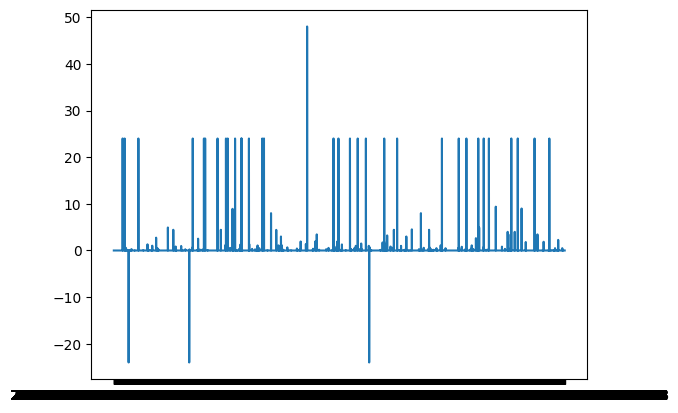

In [11]:
x = [r['date_added'] for r in recs]
y = [r['time_lost'] for r in recs]
plt.plot(x, y) 
plt.show()

<a class="anchor" id="raw_analysis"></a>
## Raw Content Analysis

### Example of one record

In [22]:
rec = recs[0]
rec

{'id': '0005d0e0-6de7-4857-b658-cfca7147374a',
 'site_id': 'summit',
 'message_text': 'The moveShutterMainDoor command Fail\r\n\r\n\r\nwe try the parameter with uppercase now\r\n\r\n\r\n open: False\r\n\r\n\r\n\r\n\r\nError in run\r\nTraceback (most recent call last):\r\n  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/asyncio/tasks.py", line 500, in wait_for\r\n    return fut.result()\r\n           ^^^^^^^^^^^^\r\n  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/lsst/ts/salobj/topics/remote_command.py", line 239, in _get_next_ackcmd\r\n    await self._next_ack_event.wait()\r\n  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/asyncio/locks.py", line 213, in wait\r\n    await fut\r\nasyncio.exceptions.CancelledError\r\n\r\n\r\nThe above exception was the direct cause of the following exception:\r\n\r\n\r\nTraceback (most recent call last):\r\n  File "/opt/lsst/software/stack/conda/envs/ls

In [26]:
msg = rec["message_text"]
print(msg)

The moveShutterMainDoor command Fail


we try the parameter with uppercase now


 open: False




Error in run
Traceback (most recent call last):
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/asyncio/tasks.py", line 500, in wait_for
    return fut.result()
           ^^^^^^^^^^^^
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/lsst/ts/salobj/topics/remote_command.py", line 239, in _get_next_ackcmd
    await self._next_ack_event.wait()
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio.exceptions.CancelledError


The above exception was the direct cause of the following exception:


Traceback (most recent call last):
  File "/opt/lsst/software/stack/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/lsst/ts/salobj/topics/remote_command.py", line 189, in next_ackcmd
    ackcmd = await self._wait_task
             ^^^^^^^

<a class="anchor" id="elicitation"></a>
## Stakeholder Elicitation